In [1]:
from cgmtools import utils
from cgmtools.forecast import lstm
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import time

Using TensorFlow backend.


In [2]:
# Load full data set from pickle file (see data_wrangler.py)
dfs_full = pkl.load(open('../../data/dfs_py3.pkl', 'rb'))

# Keep only patients with more than `THRESHOLD` days of CGM acquisition
_threshold = datetime.timedelta(days=3.5)  # default
dfs = utils.filter_patients(dfs_full, _threshold)

In [3]:
burn_in = 300  # burn-in samples used to learn the best order via cv
# n_splits = 15
ph = 18  # prediction horizon
w_size = 36

# Get patients list
patients = list(dfs.keys())

# Iterate on the patients
# for count, idx in enumerate(patients):
count , idx = 0, patients[42]
print("Evaluating patient {}/{}".format(count, len(patients)))
# Train/test split
df = utils.gluco_extract(dfs[idx], return_df=True)
train_df0 = df.iloc[:burn_in]
test_df0 = df.iloc[burn_in:]

# preprocess the dataset
# BEWARE! Do not use the trainig set to learn the scaling parameters
scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_df0)
test_data = scaler.transform(test_df0)

# Create LSTM suitable {X, Y} dataset
X_tr, Y_tr = lstm.create_XY_dataset(train_data, window_size=w_size)
X_ts, Y_ts = lstm.create_XY_dataset(test_data, window_size=w_size)

# Reshape in KRLS suitable {X, Y} dataset
X_tr = X_tr.squeeze()
X_ts = X_ts.squeeze()

Evaluating patient 0/160


In [86]:
# Create cross-validated LSTM model
param_grid = {'C': np.logspace(-1, 8, 10),
              'kernel': ['poly', 'rbf'],
              'degree': np.arange(1, 5),
              'gamma': np.logspace(-7, -1, 10)}

model = GridSearchCV(SVR(), param_grid=param_grid, n_jobs=-1)

In [87]:
tic = time.time()
# Fit the model
model.fit(X_tr, Y_tr)
print("Fitting time: {} seconds".format(time.time() - tic))

Fitting time: 2.5333364009857178 seconds


In [95]:
model.best_params_

{'C': 100000.0, 'degree': 1, 'gamma': 4.6415888336127723e-05, 'kernel': 'rbf'}

In [76]:
def online_forecast(test_data, test_labels, model, scaler, ph=18,
                    verbose=False):
    # Argument check
    if ph <= 0:
        raise Exception('ph must be at least 1')

    errs_dict = {'err_18': [], 'err_12': [], 'err_6': []}
    forecast_dict = {'ts': [], 'sigma': [], 'conf_int': []}
    w_size = test_data.shape[1]

    for t in range(test_data.shape[0] - ph):
        if t % 200 == 0 and verbose:
            print("Forecasting t = {}/{}".format(t, test_data.shape[0]))
        _X_ts_next = test_data[t]#.reshape(1, w_size, 1)

        y_pred = forecast(model, n_steps=ph, test_point=_X_ts_next)

        # Get back to original dimensions
        y_pred = scaler.inverse_transform(y_pred)
        y_future_real = scaler.inverse_transform(test_labels[t:t + ph])
        abs_pred_err = np.abs(y_pred - y_future_real)

        # Save errors
        errs_dict['err_18'].append(abs_pred_err[17])
        errs_dict['err_12'].append(abs_pred_err[11])
        errs_dict['err_6'].append(abs_pred_err[5])

        forecast_dict['ts'].append(y_pred[0])

    # Return numpy.array
    forecast_dict['ts'] = np.array(forecast_dict['ts'])
    return errs_dict, forecast_dict

def forecast(model=None, n_steps=1, test_point=None):
    if n_steps <= 0:
        raise Exception('n_steps must be at least 1')

    # Init the prediction vector
    y_pred = np.zeros(n_steps)

    # Start with the current test point
    _next_test_point = test_point
    w_size = _next_test_point.shape[0]

    # Iterate on the prediction horizon
    for step in range(n_steps):
        # Forecast one-step-ahead
        y_pred[step] = model.predict(_next_test_point)
        # Shift one-step-ahead the window
        _next_test_point = np.reshape(np.append(_next_test_point[1:],
                                                y_pred[step]), (w_size,))
    return y_pred


In [77]:
import warnings
warnings.filterwarnings('ignore')

In [78]:
# Predict the ph and save the errors
tic = time.time()
errs, forecast = online_forecast(X_ts, Y_ts, model, scaler, ph=18,
                                 verbose=True)
print("Predicting time: {} seconds".format(time.time() - tic))
error_summary = utils.forecast_report(errs)
print(error_summary)
# pkl.dump(error_summary, open(idx+'.pkl', 'wb'))
# pkl.dump({'tr_XY': [X_tr, Y_tr],
#           'ts_XY': [X_ts, Y_ts]}, open(idx+'_data_.pkl', 'wb'))
# model.save(idx+'_model_.h5')

Forecasting t = 0/1381
Forecasting t = 200/1381
Forecasting t = 400/1381
Forecasting t = 600/1381
Forecasting t = 800/1381
Forecasting t = 1000/1381
Forecasting t = 1200/1381
Predicting time: 2.6463873386383057 seconds
           30       60       90
MAE    23.138  33.6163   37.915
RMSE  28.2187  40.7911  45.6578


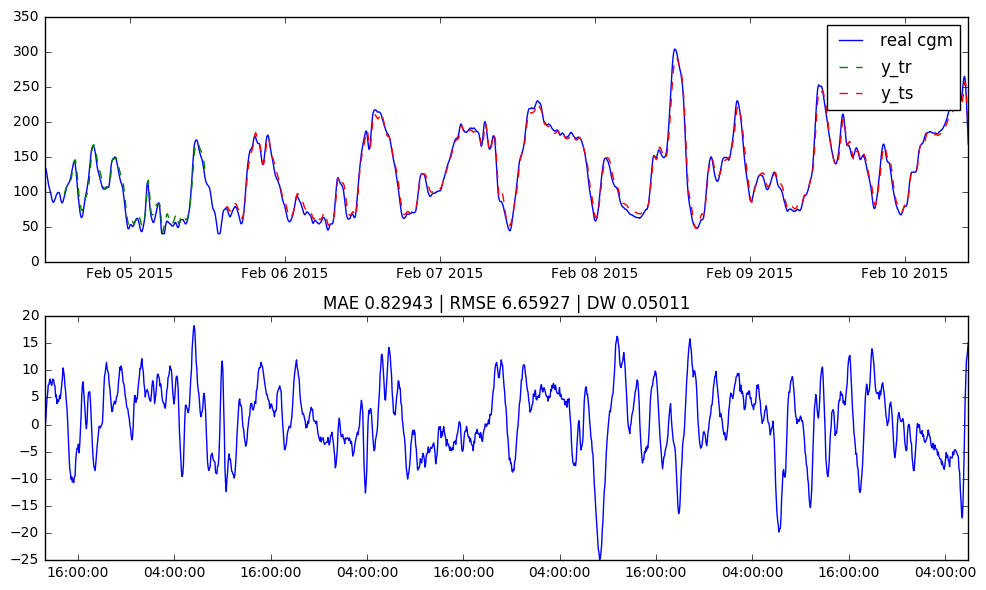

In [79]:
# -- Plotting -- #
import statsmodels.api as sm
import numpy as np
%matplotlib inline

Y_pred_tr = model.predict(X_tr)
Y_pred_ts = model.predict(X_ts)  # maybe its just forecast['ts']
Y_pred_tr_plot = scaler.inverse_transform(Y_pred_tr)
Y_pred_ts_plot = scaler.inverse_transform(Y_pred_ts)
plt.figure(figsize=(10, 6), dpi=300)
plt.subplot(211)
plt.plot(df.index, df.values, label='real cgm')
plt.plot(df.index[w_size:burn_in], Y_pred_tr_plot.ravel(), '--',
         label='y_tr')
plt.plot(df.index[burn_in+w_size:], Y_pred_ts_plot.ravel(), '--',
         label='y_ts')
plt.legend()

residuals = Y_pred_ts_plot.ravel() - df.values[burn_in+w_size:].ravel()
mae = np.mean(residuals)
rmse = np.sqrt(np.mean(residuals ** 2))
DW = sm.stats.durbin_watson(residuals)

plt.subplot(212)
plt.plot(df.index[burn_in:-w_size], residuals)
plt.title("MAE {:2.5f} | RMSE {:2.5f} | DW {:2.5f}".format(mae, rmse, DW))
plt.tight_layout()
# plt.savefig(idx+'.png')